# Loading word embeddings

In [1]:
import io
import numpy as np

In [2]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
import os 

In [6]:
path = "/Users/avij1/Desktop/imp_shit/fasttext/MUSE/dumped/debug/375u9teo6w"
p2 = "/Users/avij1/Desktop/imp_shit/fasttext/MUSE/dumped/debug/375u9teo6w/vectors-hi.txt"
# path = '/Users/avij1/Desktop/imp_shit/fasttext/MUSE/dumped/debug/w1c3c03p4w'

In [7]:
os.listdir(path)

['params.pkl',
 'vectors-en.txt',
 'vectors-hi.txt',
 'best_mapping.pth',
 'train.log']

In [8]:

src_path = os.path.join(path,'vectors-hi.txt')
tgt_path = os.path.join(path,'vectors-en.txt')
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

# Get nearest neighbors

In [9]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [10]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.4227 - dog
0.4182 - hat
0.4164 - लेखसभी
0.3989 - needing


In [11]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.3292 - rss
0.3192 - stubs
0.3112 - ref
0.3111 - wp
0.3064 - articles


# Visualize multilingual embeddings

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.10


In [13]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0, flags=flags)
/anaconda2/envs/fasttext/lib/python3.6/site-packages/matplotlib/backends/backend_a

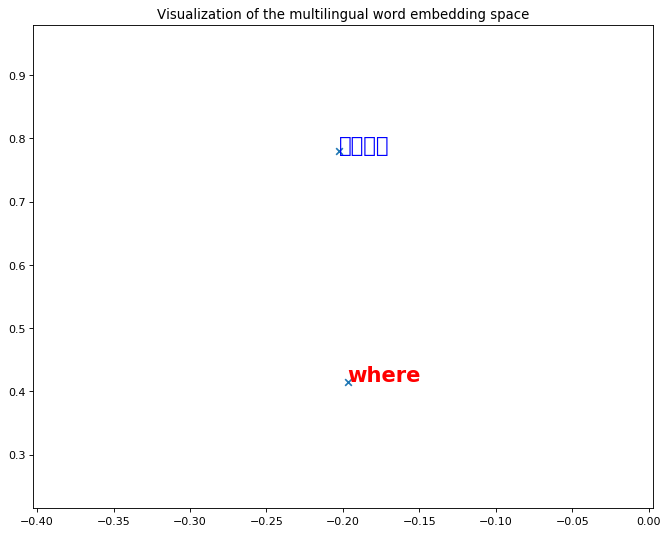

In [16]:
# get 5 random input words
src_words = ['कहाँ' ] 
tgt_words = ['where']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

In [18]:
import torch 

In [19]:
map1 = torch.load(os.path.join(path,'best_mapping.pth'))

In [20]:
map1

array([[ 0.01308666, -0.00946762,  0.08758792, ..., -0.03236237,
         0.05270232,  0.03733799],
       [ 0.07407887,  0.02124145, -0.05285997, ..., -0.0092205 ,
        -0.07361791,  0.07491986],
       [ 0.04116647, -0.03698866,  0.00020679, ..., -0.02390712,
         0.08679352, -0.00853956],
       ...,
       [ 0.00909949, -0.03637621,  0.00812729, ..., -0.02400344,
         0.12105906,  0.03065394],
       [ 0.01647672,  0.02596837, -0.00890792, ..., -0.0957305 ,
         0.05216065,  0.12187852],
       [-0.00297859, -0.12286018,  0.00149462, ..., -0.01722991,
         0.01299748,  0.00137717]], dtype=float32)

In [21]:
map1.shape

(300, 300)